In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
# 由於GPT-2沒有PAD token所以使用EOS Token
tokenizer.pad_token_id = tokenizer.eos_token_id 

# 讀取CSV檔案並只選取指定的3個欄位
df = pd.read_csv('squad2.0_converted.csv', usecols=['context', 'question', 'answer'])
df = df.fillna('nan')

In [2]:
# 加入Prompt
df['context'] = '### Context:\n' + df['context']
df['question'] = '\n### Question:\n' + df['question']

# 在答案後方加入EOS token表示文本結尾
df['answer'] = '\n### Answer:\n' + df['answer'] + tokenizer.eos_token 

In [3]:
train_df, valid_df = train_test_split(df, train_size=0.8, random_state=46, shuffle=True)
print(train_df['context'][0], end='')
print(train_df['question'][0], end='')
print(train_df['answer'][0])

### Context:
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
### Question:
When did Beyonce start becoming popular?
### Answer:
in the late 1990s<|endoftext|>


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class SquadDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        item = self.dataframe.iloc[index]
        return item['context'], item['question'], item['answer']
       
    def __len__(self):
        return len(self.dataframe)
    
    # 將文本進行分詞
    def tokenize_data(self, texts, max_length=512):
        tokenized_inputs = self.tokenizer(
            list(texts),
            truncation=True,
            padding='longest',
            max_length=max_length,
            return_tensors='pt',
        )
        
        return tokenized_inputs.input_ids, tokenized_inputs.attention_mask

    # 定義數據加載過程中的數據整理方法
    def collate_fn(self, batch):
        contexts, questions, answers = zip(*batch)
        
        # 輸入和答案
        question_ids, question_attention_mask = self.tokenize_data(questions)
        answer_ids, answer_attention_mask = self.tokenize_data(answers)
        context_ids, context_attention_mask = self.tokenize_data(contexts, max_length=1024-answer_ids.shape[1]-question_ids.shape[1])
       

        # 模型的輸入 = context_ids + question_ids + answer_ids
        combined_input_ids = torch.cat((context_ids, question_ids, answer_ids), dim=-1)
        # 模型的MASK = context_attention_mask + question_attention_mask + answer_attention_mask
        combined_attention_mask = torch.cat((context_attention_mask, question_attention_mask, answer_attention_mask), dim=-1)

        # 模型的標籤 = context_ids * [-100] + question_ids * [-100] + answer_ids + [EOS] 
        context_ignore_mask = torch.full((context_ids.shape[0], context_ids.shape[-1]), -100) # 產生context_ids * [-100]
        question_ignore_mask = torch.full((question_ids.shape[0], question_ids.shape[-1]), -100) # 產生question_ids * [-100]
        answer_ignore_indices = (answer_attention_mask == 0) # 找出Answer的[PAD] idx
        answer_ids[answer_ignore_indices] = -100 # 將Answer為[PAD]的部分轉換成-100
        combined_answers = torch.cat((context_ignore_mask, question_ignore_mask, answer_ids), dim=-1) #context_ignore_mask + question_ignore_mask + answer_ids

        return {
            'input_ids': combined_input_ids,
            'attention_mask': combined_attention_mask,
            'labels': combined_answers,
        }

# 建立資料集
trainset = SquadDataset(train_df, tokenizer)
validset = SquadDataset(valid_df, tokenizer)

# 創建 DataLoader
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=trainset.collate_fn)
valid_loader = DataLoader(validset, batch_size=4, shuffle=True, collate_fn=validset.collate_fn)


In [5]:
import torch.optim as optim
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from transformers import AutoModelForCausalLM

# 訓練設置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2").to(device)

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=len(train_loader) * 0.2, 
        num_training_steps=len(train_loader) * 10, 
        num_cycles=1, 
)

Valid Epoch 0: 100%|██████████| 6506/6506 [02:27<00:00, 44.04it/s, loss=0.021]


Saving Model With Loss 0.54285
Train Loss: 0.65651| Valid Loss: 0.54285| Best Loss: 0.54285



Valid Epoch 1: 100%|██████████| 6506/6506 [02:29<00:00, 43.44it/s, loss=0.579]


Saving Model With Loss 0.50105
Train Loss: 0.51836| Valid Loss: 0.50105| Best Loss: 0.50105



Valid Epoch 2: 100%|██████████| 6506/6506 [02:28<00:00, 43.94it/s, loss=0.169]


Saving Model With Loss 0.48696
Train Loss: 0.40478| Valid Loss: 0.48696| Best Loss: 0.48696



Valid Epoch 3: 100%|██████████| 6506/6506 [02:29<00:00, 43.55it/s, loss=0.441]


Saving Model With Loss 0.47061
Train Loss: 0.30350| Valid Loss: 0.47061| Best Loss: 0.47061



Valid Epoch 4: 100%|██████████| 6506/6506 [02:27<00:00, 44.03it/s, loss=0.625]


Train Loss: 0.21038| Valid Loss: 0.48044| Best Loss: 0.47061



Valid Epoch 5: 100%|██████████| 6506/6506 [02:28<00:00, 43.72it/s, loss=0.584]


Train Loss: 0.13366| Valid Loss: 0.48269| Best Loss: 0.47061



Valid Epoch 6: 100%|██████████| 6506/6506 [02:28<00:00, 43.84it/s, loss=0.653]


------------------------------------
|Model can't improve, stop training|
------------------------------------


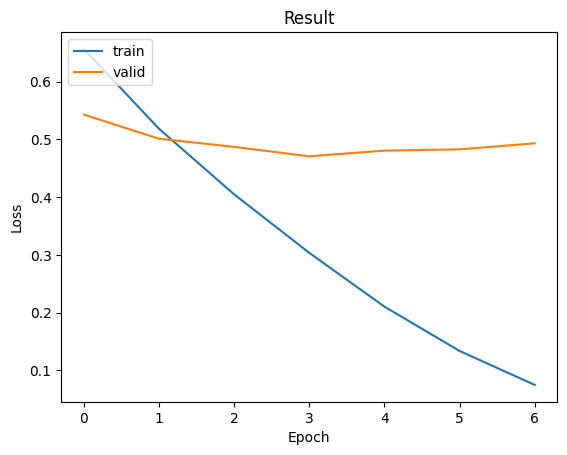

In [ ]:
from trainer import Trainer
trainer = Trainer(
    epochs=10, 
    train_loader=train_loader, 
    valid_loader=valid_loader,
    model=model, 
    optimizer=[optimizer],
    scheduler=[scheduler],
    early_stopping=3,
    device=device
)
trainer.train()

In [6]:
def inference(model, tokenizer, context, question, device):
    # 準備輸入數據
    inference_data = f"{context}{question}\n### Answer:\n"
    # 進行編碼和截斷
    try:
        inputs = tokenizer(inference_data, max_length=1024, truncation=True, return_tensors='pt').to(device)
        # 禁用梯度計算，進行生成
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=1024, do_sample=False)
        
        # 解碼並提取答案部分
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = generated_text.split('\n### Answer:\n')[1].strip()
        
        return answer
    except:
        return 'Error'

# 載入模型和設定評估模式
model.load_state_dict(torch.load('model.ckpt'))
model.eval()

# 指定要進行推理的索引
idx = 7

# 準備推理資料
context = valid_df['context'].values[idx]
question = valid_df['question'].values[idx]
answer = valid_df['answer'].values[idx]


# 進行推理
model.generation_config.pad_token_id = tokenizer.eos_token_id
model_answer = inference(model, tokenizer, context, question, device)


# 輸出原始上下文、問題、真實答案和模型生成的答案
print(f"{context}")
print(f"{question}")
print(f"{answer.split(tokenizer.eos_token)[0]}")
print("\n### Model Answer:\n" + model_answer)


### Context:
At her Silver Jubilee in 1977, the crowds and celebrations were genuinely enthusiastic, but in the 1980s, public criticism of the royal family increased, as the personal and working lives of Elizabeth's children came under media scrutiny. Elizabeth's popularity sank to a low point in the 1990s. Under pressure from public opinion, she began to pay income tax for the first time, and Buckingham Palace was opened to the public. Discontent with the monarchy reached its peak on the death of Diana, Princess of Wales, though Elizabeth's personal popularity and support for the monarchy rebounded after her live television broadcast to the world five days after Diana's death.

### Question:
What did Elizabeth start paying in the 1990 s?

### Answer:
income tax

### Model Answer:
income tax


In [7]:
def calculate_accuracy(model, tokenizer, valid_df, validset, device):
    contexts = valid_df['context'].values
    questions = valid_df['question'].values
    answers = valid_df['answer'].values
    correct = 0
    for context, question, true_answer in zip(contexts, questions, answers):
        model_answer = inference(model, tokenizer, context, question, device)
        true_answer=  true_answer.split('\n### Answer:\n')[1].replace('<|endoftext|>', '')
        if model_answer.strip() == true_answer.strip():
            correct += 1
    return correct / len(validset)

accuracy = calculate_accuracy(validset, valid_loader, model, device)
print(f'模型準確率: {accuracy:.2%}')

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


模型準確率: 16.90%
